# **Import**

In [2]:
!pip install pycadet

In [1]:
import numpy as np
from astropy.io import fits
from scipy.ndimage import center_of_mass

import matplotlib.pyplot as plt

from pycadet import make_prediction, rebin, decompose, make_3D_cavity, CADET

2023-07-17 18:16:18.813377: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 18:16:19.621784: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



No GPUs detected. Using a CPU.


2023-07-17 18:16:20.872596: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-17 18:16:21.062104: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# **Data**

The ***CADET*** pipeline inputs either raw *Chandra* images in units of counts (numbers of captured photons) or exposure-corrected images. When using exposure-corrected images, images should be normalized by the lowest pixel value so all pixels are higher than or equal to 1. For images with many point sources, they should be filled with surrounding background level using Poisson statistics ([dmfilth](https://cxc.cfa.harvard.edu/ciao/ahelp/dmfilth.html) within [CIAO](https://cxc.harvard.edu/ciao/)).

In [3]:
!wget "https://github.com/tomasplsek/CADET/raw/main/NGC4649.fits" -O "NGC4649.fits"
!wget "https://github.com/tomasplsek/CADET/raw/main/NGC4778.fits" -O "NGC4778.fits"

--2023-06-28 00:01:40--  https://github.com/tomasplsek/CADET/raw/main/NGC4649.fits
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tomasplsek/CADET/main/NGC4649.fits [following]
--2023-06-28 00:01:41--  https://raw.githubusercontent.com/tomasplsek/CADET/main/NGC4649.fits
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2301120 (2,2M) [application/octet-stream]
Saving to: ‘NGC4649.fits’

NGC4649.fits        100%[===================>]   2,19M  2,78MB/s    in 0,8s    

2023-06-28 00:01:42 (2,78 MB/s) - ‘NGC4649.fits’ saved [2301120/2301120]



(512, 512)

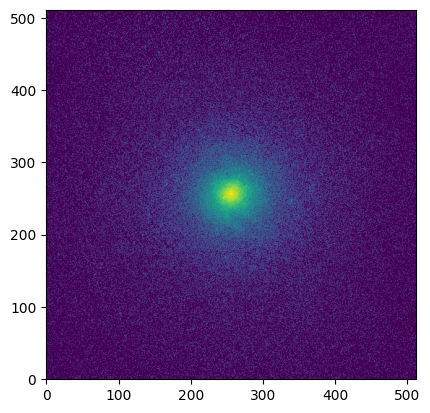

In [2]:
data = fits.getdata("NGC4649.fits")

plt.imshow(np.log10(data+1), origin="lower");

data.shape

# **Rebin**

Convolutional part of the ***CADET*** pipeline can only input 128x128 images. As a part of the pipeline, input images are therefore being cropped to a size specified by parameter scale (size = scale * 128 pixels) and re-binned to 128x128 images. By default, images are probed on 4 different scales (1,2,3,4). The size of the image inputted into the pipeline therefore needs to at least 512x512 pixels (minimal input size differs if non-default scales are used) and images should be centred at the centre of the galaxy. The re-binning is performed using *Astropy* and *Numpy* libraries and can only handle integer binsizes. For floating point number binning, we recommend using [dmregrid](https://cxc.cfa.harvard.edu/ciao/ahelp/dmregrid.html) and applying ***CADET*** model manually (see Convolutional part).

In [3]:
from pycadet import rebin

In [4]:
data, wcs = rebin("NGC4649.fits", scale=2, ra="12:43:40.0057", dec="11:33:10.456")

(128, 128)

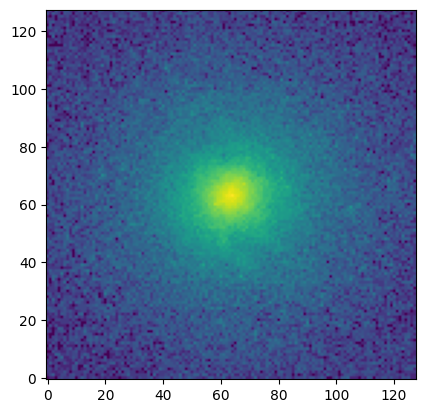

In [5]:
plt.imshow(np.log10(data+1), origin="lower");

data.shape

# **Make prediction**

`data` - numpy array of shape (128, 128), input image\

In [6]:
from pycadet import make_prediction

In [7]:
%time pred = make_prediction(data)

CPU times: user 17.8 s, sys: 144 ms, total: 18 s
Wall time: 3.7 s


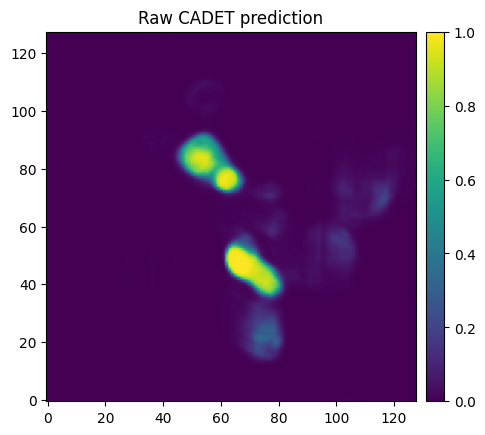

In [8]:
from matplotlib.colors import Normalize

plt.title("Raw CADET prediction")
plt.imshow(pred, origin="lower", norm=Normalize(0,1))
plt.colorbar(fraction=0.046, pad=0.02);

## **Shifting**

To suppress uncertainties connected with improper image centering as well as with activating slightly different neurons in the CADET model, the CADET pipeline includes the possibility to shift the centre of the input image by +/- 1 pixel in both X and Y directions. If `shift=True`, the final predictions is thus averaged from 9 differently shifted input images.

When using the shifting option 

In [9]:
data, wcs = rebin("NGC4649.fits", scale=2, shift=True, ra="12:43:40.0057", dec="11:33:10.456")

data.shape

(130, 130)

In [10]:
%time pred = make_prediction(data, shift=True)

2023-07-17 18:17:26.333681: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2023-07-17 18:17:26.333875: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2023-07-17 18:17:26.386098: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2023-07-17 18:17:26.473906: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2023-07-17 18:17:26.498169: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 199229440 exceeds 10% of free system memory.


CPU times: user 2min 40s, sys: 1.83 s, total: 2min 41s
Wall time: 26.7 s


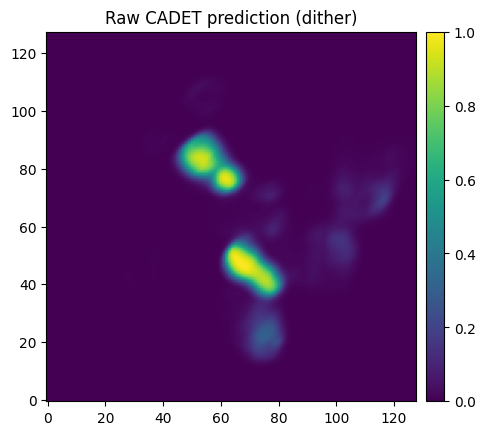

In [11]:
plt.title("Raw CADET prediction (shift)")
plt.imshow(pred, origin="lower", norm=Normalize(0,1))
plt.colorbar(fraction=0.046, pad=0.02);

# **Decompose**

Before being decomposed by the DBSCAN algorithm, pixel-wise predictions produced by the convolutional part of the ***CADET*** pipeline need to be further thresholded. In order to simultaneously calibrate the volume error and false positive rate, we introduced two discrimination thresholds (for more info see [Plšek et al. 2023]()) and their default values are 0.4 and 0.6, respectively. Nevertheless, both discrimination thresholds are changeable and can be set to an arbitrary value between 0 and 1.

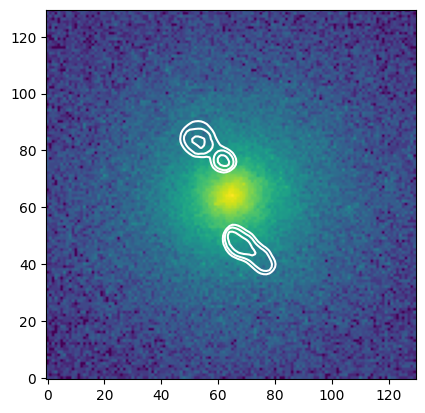

In [12]:
plt.imshow(np.log10(data+1), origin="lower");

plt.contour(pred, levels=[0.5, 0.7, 0.9], colors="white");

In [13]:
from pycadet import decompose

In [14]:
cavities = decompose(pred, th1=0.5, th2=0.7)

len(cavities), cavities[0].shape

(2, (128, 128))

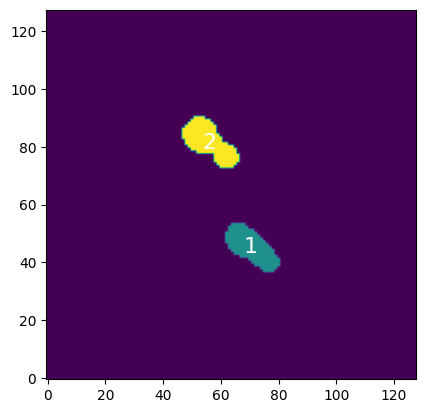

In [15]:
cavs = np.zeros((128,128))
for i, cav in enumerate(cavities):
    cavs += (i+1) * np.where(cav > 0, 1, 0)

plt.imshow(cavs, origin="lower")
for i, cav in enumerate(cavities):
    plt.text(*center_of_mass(cav)[::-1], i+1, fontsize=16, ha="center", va="center", c="w")

# **Make 3D cavity**

The volumes of X-ray cavities are calculated under the assumption of rotational symmetry along the direction from the galactic centre towards the centre of the cavity (estimated as *center of mass*). The cavity depth in each point along that direction is then assumed to be equal to its width. Thereby produced 3D cavity models are stored in the `.npy` format and can be used for further caclulation (e.g. cavity energy estimation)

In [16]:
from pycadet import make_3D_cavity

In [17]:
cube = make_3D_cavity(cavities[0])
cube += make_3D_cavity(cavities[1])

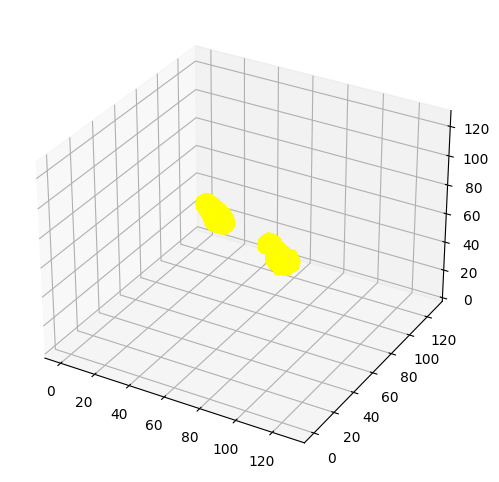

In [18]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.voxels(cube, edgecolor="yellow", facecolors="yellow", alpha=0.5);

# **CADET script**

The `CADET.py` script loads a FITS file specified by the `filename` argument, which is located in the same folder as the main `CADET.py` script. The script creates a folder of the same name as the FITS file, and saves corresponding pixel-wise as well as decomposed cavity predictions into the FITS format while also properly preserving the WCS coordinates. On the output, there is also a PNG file showing decomposed predictions for individual scales.

In [1]:
from pycadet import CADET

2023-07-19 14:06:55.352123: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 14:06:57.002730: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


No GPUs detected. Using a CPU.



2023-07-19 14:06:59.390724: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-19 14:06:59.567761: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
CADET("NGC4649.fits", scales=[1,2,3,4], th1=0.4, th2=0.8)

NameError: name 'CADET' is not defined

---- Running CADET ----
Reading file: NGC4778.fits

Original image size: 2510x1916 pixels
Selected scales: [1, 2, 3, 4, 5]
RA:  12:53:05.6621 hours
DEC: -9:12:14.883 degrees

Creating directories:
NGC4778/
  ├ predicitons/
  ├ decomposed/
  └ cubes/

Processing images with CADET:
128x128 pixels:    WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fa590209240> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
de

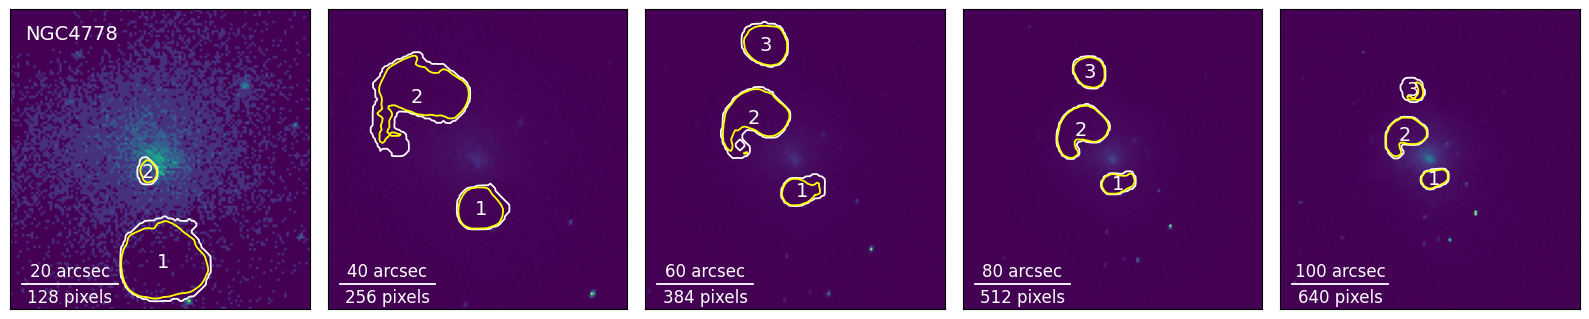

In [3]:
CADET("NGC4778.fits", scales=[1,2,3,4,5], th1=0.4, th2=0.7, ra="12:53:05.6621", dec="-9:12:14.883")